In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%matplotlib inline
from musc_genomics.data_import import cosmic, api, prep
from musc_genomics import data, common
pd.set_option('max_info_rows', int(1E9))

In [2]:
d_cl = cosmic.get_cosmic_rel6_data('Cell_Lines_Details.xlsx')
d_cl.keys()

dict_keys(['Decode', 'COSMIC tissue classification', 'Cell line details'])

In [3]:
# Read in sheet containing cell line id (TUMOR_ID) and cosmic id
m_rename = {
    'Sample Name': 'TUMOR_ID', 
    'COSMIC identifier': 'COSMIC_ID', 
    'Cancer Type(matching TCGA label)': 'CANCER_TYPE'
}
d_cl_main = d_cl['Cell line details']\
    .rename(columns=lambda c: c.replace('\n', ''))\
    .rename(columns=m_rename)\
    .assign(TUMOR_ID=lambda x: x['TUMOR_ID'].astype(str).str.strip().str.upper())
    
# Ignore records with no TUMOR_ID or COSMIC_ID, since these will not be useful when joined on CGDS data
d_cl_main = d_cl_main[d_cl_main['TUMOR_ID'].notnull()]
d_cl_main = d_cl_main[d_cl_main['COSMIC_ID'].notnull()]

# Normalize tumor id values to avoid common errors in joins / aggregations
d_cl_main['TUMOR_ID'] = common.normalize_tumor_ids(
    d_cl_main['TUMOR_ID'], source=common.SRC_COSMIC6, 
    verify_integrity=True
)
    
assert not np.any(d_cl_main['TUMOR_ID'].duplicated())
assert not np.any(d_cl_main['COSMIC_ID'].duplicated())

d_cl_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 13 columns):
TUMOR_ID                                   1001 non-null object
COSMIC_ID                                  1001 non-null float64
Whole Exome Sequencing (WES)               1001 non-null object
Copy Number Alterations (CNA)              1001 non-null object
Gene Expression                            1001 non-null object
Methylation                                1001 non-null object
DrugResponse                               1001 non-null object
GDSCTissue descriptor 1                    1001 non-null object
GDSCTissuedescriptor 2                     1001 non-null object
CANCER_TYPE                                826 non-null object
Microsatellite instability Status (MSI)    986 non-null object
Screen Medium                              1001 non-null object
Growth Properties                          999 non-null object
dtypes: float64(1), object(12)
memory usage: 109.5+ KB


In [4]:
# Read in sheet containing site and histology for each cell line
d_cl_tissue = d_cl['COSMIC tissue classification']\
    .rename(columns={'Line': 'TUMOR_ID', 'Site': 'SITE', 'Histology': 'HISTOLOGY'})\
    .assign(TUMOR_ID=lambda x: x['TUMOR_ID'].astype(str).str.strip().str.upper())

# Ignore records with no TUMOR_ID, since these will not be useful when joined on CGDS data
d_cl_tissue = d_cl_tissue[d_cl_tissue['TUMOR_ID'].notnull()]

# Normalize tumor id values to avoid common errors in joins / aggregations
d_cl_tissue['TUMOR_ID'] = common.normalize_tumor_ids(
    d_cl_tissue['TUMOR_ID'], source=common.SRC_COSMIC6, 
    verify_integrity=True
)

assert not np.any(d_cl_tissue['TUMOR_ID'].duplicated())
assert not np.any(d_cl_tissue['COSMIC_ID'].duplicated())

d_cl_tissue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 0 to 1028
Data columns (total 4 columns):
TUMOR_ID     1029 non-null object
COSMIC_ID    1029 non-null int64
SITE         1029 non-null object
HISTOLOGY    1029 non-null object
dtypes: int64(1), object(3)
memory usage: 40.2+ KB


In [7]:
d_cl_all = pd.merge(
    d_cl_main.assign(ID1=np.arange(len(d_cl_main))), 
    d_cl_tissue.assign(ID2=np.arange(len(d_cl_tissue))), 
    on=['TUMOR_ID', 'COSMIC_ID'], how='outer'
).rename(columns={
    'Whole Exome Sequencing (WES)': 'HAS_ES',
    'Copy Number Alterations (CNA)': 'HAS_CN',
    'Gene Expression': 'HAS_GE',
    'Methylation': 'HAS_ME',
    'DrugResponse': 'HAS_DR'
})

assert d_cl_all['TUMOR_ID'].value_counts().max() == 1

d_cl_all = d_cl_all.filter(regex='TUMOR_ID|COSMIC_ID|^HAS|SITE|HISTOLOGY|^ID|CANCER_TYPE')
d_cl_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 0 to 1028
Data columns (total 12 columns):
TUMOR_ID       1029 non-null object
COSMIC_ID      1029 non-null float64
HAS_ES         1001 non-null object
HAS_CN         1001 non-null object
HAS_GE         1001 non-null object
HAS_ME         1001 non-null object
HAS_DR         1001 non-null object
CANCER_TYPE    826 non-null object
ID1            1001 non-null float64
SITE           1029 non-null object
HISTOLOGY      1029 non-null object
ID2            1029 non-null int64
dtypes: float64(2), int64(1), object(9)
memory usage: 104.5+ KB


In [8]:
d_dr = cosmic.get_cosmic_rel6_data('v17_fitted_dose_response.xlsx')
d_dr = d_dr['Export Worksheet']
d_dr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224510 entries, 0 to 224509
Data columns (total 8 columns):
DATASET_VERSION        224510 non-null int64
IC50_RESULTS_ID        224510 non-null int64
COSMIC_ID              224510 non-null int64
DRUG_ID                224510 non-null int64
MAX_CONC_MICROMOLAR    224510 non-null float64
LN_IC50                224510 non-null float64
AUC                    224510 non-null float64
RMSE                   224510 non-null float64
dtypes: float64(4), int64(4)
memory usage: 13.7 MB


In [10]:
d_rm = pd.merge(d_dr, d_cl_all.drop(['ID1', 'ID2'], axis=1), on=['COSMIC_ID'], how='left')
d_rm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224510 entries, 0 to 224509
Data columns (total 17 columns):
DATASET_VERSION        224510 non-null int64
IC50_RESULTS_ID        224510 non-null int64
COSMIC_ID              224510 non-null int64
DRUG_ID                224510 non-null int64
MAX_CONC_MICROMOLAR    224510 non-null float64
LN_IC50                224510 non-null float64
AUC                    224510 non-null float64
RMSE                   224510 non-null float64
TUMOR_ID               216576 non-null object
HAS_ES                 212774 non-null object
HAS_CN                 212774 non-null object
HAS_GE                 212774 non-null object
HAS_ME                 212774 non-null object
HAS_DR                 212774 non-null object
CANCER_TYPE            175006 non-null object
SITE                   216576 non-null object
HISTOLOGY              216576 non-null object
dtypes: float64(4), int64(4), object(9)
memory usage: 30.8+ MB


In [11]:
n = len(d_rm)
rm_cid = d_rm[d_rm['TUMOR_ID'].isnull()]['COSMIC_ID'].unique()
d_rm = d_rm[~d_rm['COSMIC_ID'].isin(rm_cid)]
print(
    'Removing {} records of {} due to no match on TUMOR ID (unique cosmic IDs for those dropped = {})'\
    .format(n - len(d_rm), n, ','.join([str(x) for x in rm_cid]))
)
d_rm.info()

Removing 7934 records of 224510 due to no match on TUMOR ID (unique cosmic IDs for those dropped = 1295743,753536,687984,724858,1240133,1290801,906850,924109,753553,1479991,1479992,1479993,1479994,1240164,907391,1298152,1298153,907284,1298154,1298158,1298159,1327776,1298161,1298162,1240156,908119,1330943,1298233,1333014,1333015,869795,907785,908464,908477,753601,1330965,1330969,688000,1330977,924242,688029,1330974,924246,1298355,1330996,925349,1330986,1480366,1330988,1298361,753611,1331031,1240225,1331046,1503374,1240227,1299074,910696,1299077,1331043,1331044,1299066)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 216576 entries, 0 to 224509
Data columns (total 17 columns):
DATASET_VERSION        216576 non-null int64
IC50_RESULTS_ID        216576 non-null int64
COSMIC_ID              216576 non-null int64
DRUG_ID                216576 non-null int64
MAX_CONC_MICROMOLAR    216576 non-null float64
LN_IC50                216576 non-null float64
AUC                    216576 non-null f

In [12]:
d_rx = cosmic.get_cosmic_rel6_data('Screened_Compounds.xlsx')
d_rx = d_rx['Export Worksheet']
d_rx = d_rx.rename(columns={'DRUG ID': 'DRUG_ID', 'DRUG NAME': 'DRUG_NAME', 'TARGET PATHWAY': 'TARGET_PATHWAY'})
d_rx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 5 columns):
DRUG_ID           265 non-null int64
DRUG_NAME         265 non-null object
SYNONYMS          149 non-null object
TARGET            264 non-null object
TARGET_PATHWAY    265 non-null object
dtypes: int64(1), object(4)
memory usage: 10.4+ KB


In [13]:
d_all = pd.merge(d_rm, d_rx, on='DRUG_ID', how='outer')
d_all = d_all.rename(columns={'LN_IC50': 'VALUE_IC50', 'AUC': 'VALUE_AUC'})
d_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216576 entries, 0 to 216575
Data columns (total 21 columns):
DATASET_VERSION        216576 non-null int64
IC50_RESULTS_ID        216576 non-null int64
COSMIC_ID              216576 non-null int64
DRUG_ID                216576 non-null int64
MAX_CONC_MICROMOLAR    216576 non-null float64
VALUE_IC50             216576 non-null float64
VALUE_AUC              216576 non-null float64
RMSE                   216576 non-null float64
TUMOR_ID               216576 non-null object
HAS_ES                 212774 non-null object
HAS_CN                 212774 non-null object
HAS_GE                 212774 non-null object
HAS_ME                 212774 non-null object
HAS_DR                 212774 non-null object
CANCER_TYPE            175006 non-null object
SITE                   216576 non-null object
HISTOLOGY              216576 non-null object
DRUG_NAME              216576 non-null object
SYNONYMS               116999 non-null object
TARGET         

In [14]:
data.save('prepared', 'response_cosmic6', d_all)

2016-08-06 18:25:35,876:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/prepared/response_cosmic6.pkl"


'/Users/eczech/data/research/musc_genomics/prepared/response_cosmic6.pkl'

# Analysis

In [16]:
dt = d_dr.pivot_table(index='COSMIC_ID', columns='DRUG_NAME', values='LN_IC50')
dt.head()

DRUG_NAME,(5Z)-7-Oxozeaenol,17-AAG,5-Fluorouracil,681640,A-443654,A-770041,AC220,AG-014699,AICAR,AKT inhibitor VIII,...,YM155,YM201636,Z-LLNle-CHO,ZG-10,ZM-447439,ZSTK474,Zibotentan,piperlongumine,rTRAIL,selumetinib
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
683665,-0.079227,0.545906,0.145949,1.439772,0.233667,0.737759,1.319686,2.462426,5.238266,1.499591,...,-4.413224,0.739898,-0.287463,0.315678,0.752087,-2.355524,5.046538,1.105754,-1.292201,2.256647
683667,NaN,0.180038,3.772202,1.993984,NaN,NaN,2.652620,NaN,9.134225,3.536580,...,-5.720567,3.011561,NaN,-0.132150,1.522715,0.746917,5.715174,0.830019,-3.318647,3.395470
684052,0.649827,1.846502,4.707996,2.643407,NaN,NaN,2.298034,1.576687,NaN,2.405422,...,-5.381500,2.574676,NaN,0.073844,3.051599,0.363181,5.128464,0.605764,-2.554841,2.353819
684055,1.526998,-0.513753,3.740453,1.758212,0.543842,3.353541,-0.383935,NaN,NaN,2.208883,...,-5.841138,0.479767,2.723620,0.428819,-0.755294,0.221963,5.523189,1.450945,-0.219360,1.605146
684057,1.322207,0.499729,1.937160,0.829353,1.701759,4.372855,1.023963,1.684171,8.124295,1.259482,...,-5.890632,-0.282872,3.044185,0.504039,0.142937,-1.944276,5.790380,2.008116,-2.207468,3.004049


In [46]:
def get_corr(method):
    d_cor = dt.corr(method=method)
    d_cor = d_cor.where(np.triu(np.ones(d_cor.shape)).astype(np.bool))
    d_cor.columns.name=None
    d_cor.index.name=None
    d_cor = d_cor.stack().reset_index()
    d_cor.columns = ['D1', 'D2', 'C']
    assert d_cor.groupby(['D1', 'D2']).size().max() == 1
    return d_cor

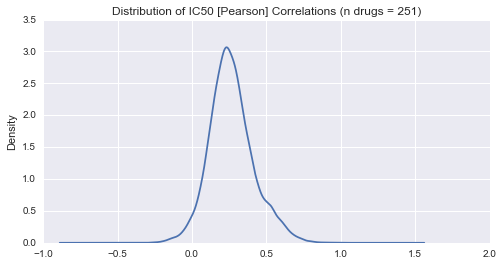

In [47]:
plt.figure(figsize=(8, 4))
d_cor = get_corr('pearson')
ax = d_cor.query("D1 != D2")['C'].plot(kind='kde')
ax.set_title('Distribution of IC50 [Pearson] Correlations (n drugs = {})'.format(len(d_cor['D1'].unique())))

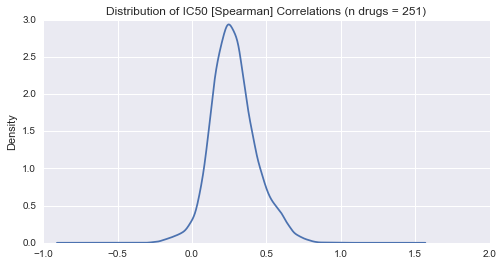

In [48]:
plt.figure(figsize=(8, 4))
d_cor = get_corr('spearman')
ax = d_cor.query("D1 != D2")['C'].plot(kind='kde')
ax.set_title('Distribution of IC50 [Spearman] Correlations (n drugs = {})'.format(len(d_cor['D1'].unique())))

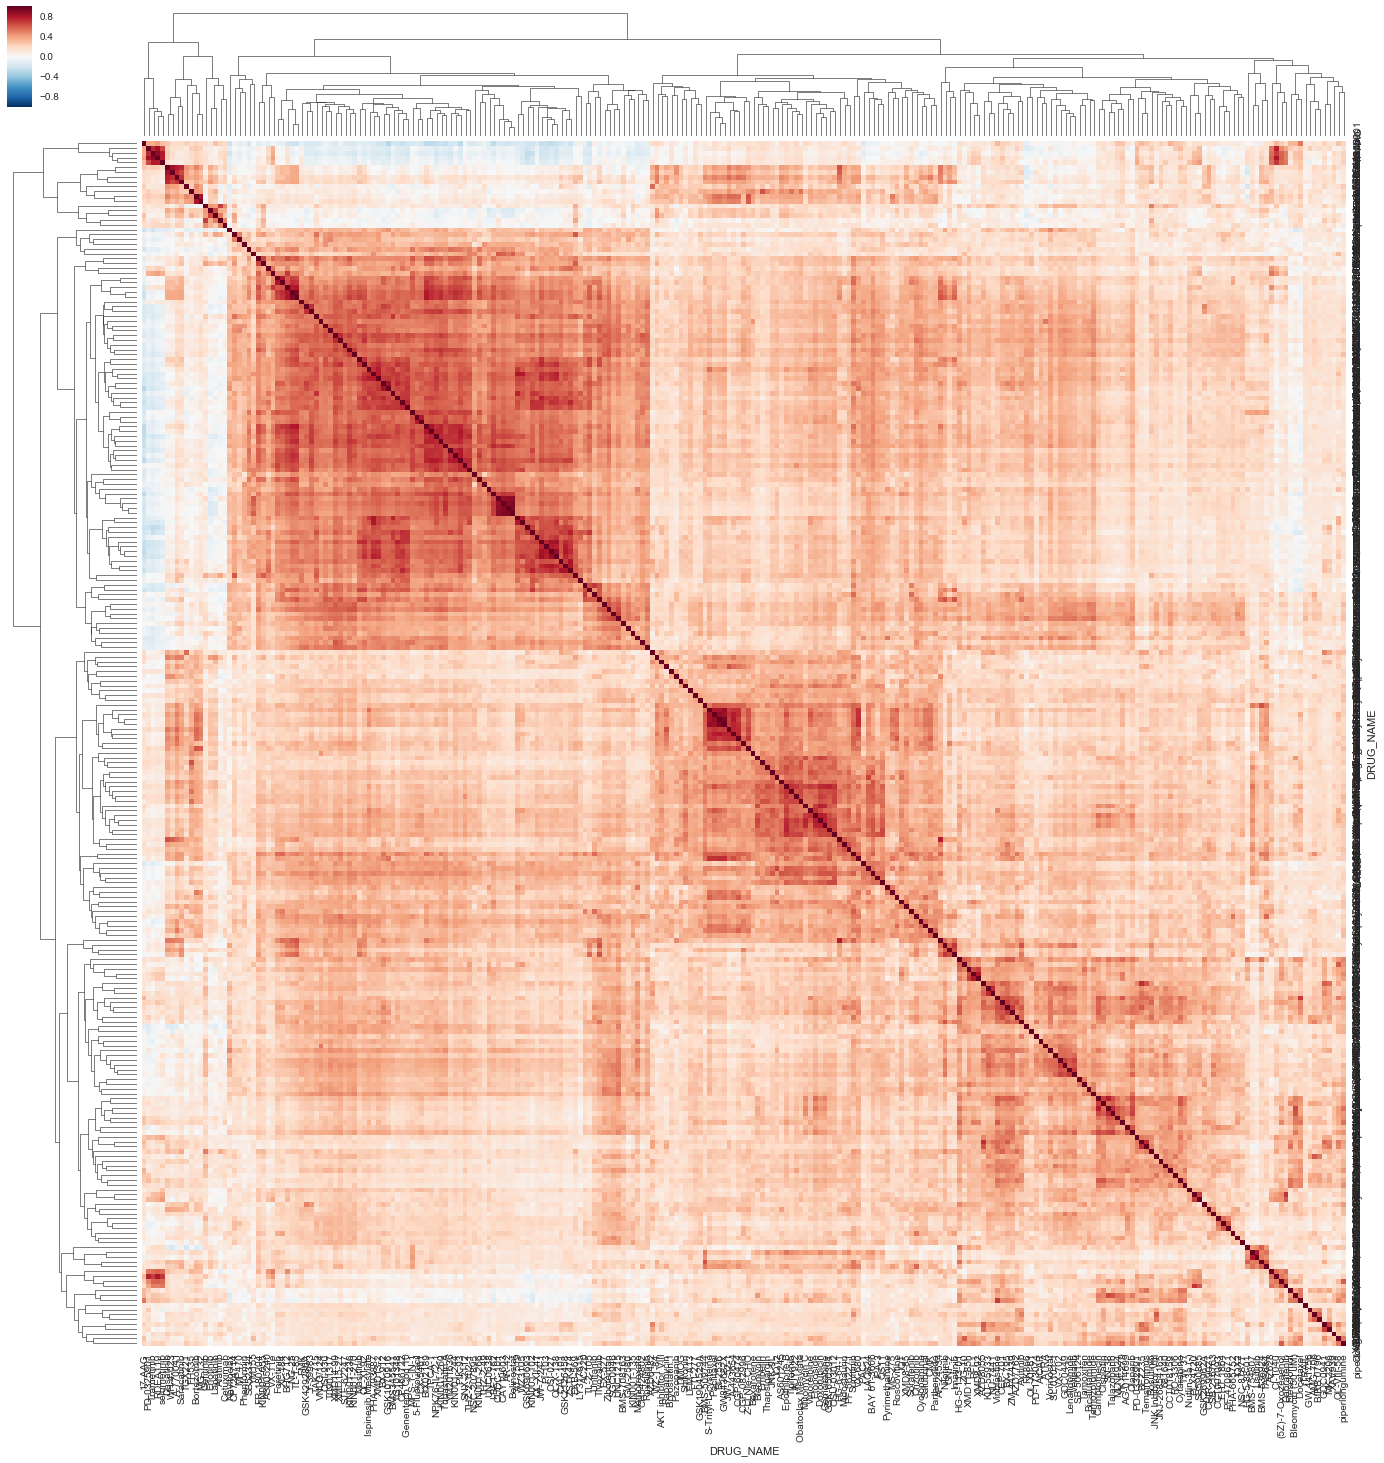

In [27]:
sns.clustermap(dt.corr(method='pearson', min_periods=50), row_cluster=True, col_cluster=True, figsize=(24, 24))

In [49]:
d_dr.groupby(['TARGET_PATHWAY', 'DRUG_NAME']).size().head()

TARGET_PATHWAY  DRUG_NAME  
ABL signaling   AP-24534       940
                Bosutinib      894
                Dasatinib      423
                GNF-2          424
                HG-5-113-01    519
dtype: int64